In [1]:
#%pip install langchain
#%pip install langchain_openai

# Import Necessary Libraries

import os
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.extractors import TitleExtractor
from llama_index.core import VectorStoreIndex
from dotenv import load_dotenv
from llama_index.llms.openai import OpenAI

import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
from llama_index.core import Settings

from langchain_openai import ChatOpenAI
from langchain_community.utilities import SerpAPIWrapper

import nest_asyncio
from diskcache import Cache
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

c:\Users\sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Apply nested asyncio to allow for nested event loops
nest_asyncio.apply()

# Load environment variables from the specified .env file
load_dotenv(r"C:\Users\sandy\Downloads\Insurance_Doc_RAG_With_LangchainLlamaIndex\keys.env")

# Retrieve the OpenAI API key from the environment variables
api_key = os.getenv("OPENAI_API_KEY")

# Initialize a persistent Chroma database client with the specified path
chroma_client = chromadb.PersistentClient(path=r"C:\Users\sandy\Downloads\Insurance_Doc_RAG_With_LangchainLlamaIndex\chroma.db")

# Define the path to the directory containing PDF documents to be processed
pdf_dir_path = r"C:\Users\sandy\Downloads\Insurance_Doc_RAG_With_LangchainLlamaIndex\New folder"

# Set the language model to be used for processing
Settings.llm = OpenAI(model="gpt-4o-mini")

# Initialize a cache to store results, with a specified cache directory
cache = Cache("./cache_V2")
#Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [3]:
#chroma_client.delete_collection("Insurance_Doc_RAG_LlamaIndex_Langchain")

In [4]:
def build_index(pdf_dir_path, storage_context):
    """Builds a vector store index from PDF documents.

    Args:
        pdf_dir_path (str): The path to the directory containing PDF documents to be indexed.
        storage_context (StorageContext): The context for storing the vector index.

    Returns:
        VectorStoreIndex: The created vector store index containing the processed documents.
    """  
    # Load documents from the specified directory
    docs = SimpleDirectoryReader(pdf_dir_path).load_data()
    
    # Create an ingestion pipeline with specified transformations
    pipeline = IngestionPipeline(
        transformations=[
            # Split documents into sentences with specified chunk size and overlap
            SentenceSplitter(chunk_size=2048, chunk_overlap=0),
            # Extract titles from the documents
            TitleExtractor(),
            # Use OpenAI's embedding model for text embedding
            OpenAIEmbedding(model_name="text-embedding-ada-002"),
            #HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2"),
        ]
    )
    
    # Run the pipeline on the loaded documents to create nodes
    nodes = pipeline.run(documents=docs)
    
    # Create a vector store index from the nodes and the provided storage context
    index = VectorStoreIndex(nodes=nodes, storage_context=storage_context)

    return index  # Return the created index

In [5]:

def data_retrieval(query, index):
    """Retrieves data based on the provided query from the specified index.

    Args:
        query (str): The query string used to search for relevant data.
        index (VectorStoreIndex): The index from which to retrieve data.

    Returns:
        list: A list of results matching the query.
    """
    # Convert the index into a retriever object for querying
    retriever = index.as_retriever()
    
    # Retrieve results based on the provided query
    results = retriever.retrieve(query)
    
    return results  # Return the retrieved results

In [6]:
def save_index():
    """Saves the vector store index to a Chroma collection.

    This function creates a new collection in the Chroma database if it does not already exist,
    initializes a vector store with that collection, and builds the index from the specified PDF documents.

    Returns:
        VectorStoreIndex: The created vector store index containing the processed documents.
    """
    # collection_list = chroma_client.list_collections()
    # if "Insurance_Doc_RAG_LlamaIndex_Langchain" not in collection_list:

    # Create a new collection in the Chroma database for storing the index
    chroma_collection = chroma_client.create_collection(name="Insurance_Doc_RAG_LlamaIndex_Langchain")
    
    # else:
    #     chroma_collection = chroma_client.get_collection(name="Insurance_Doc_RAG_LlamaIndex_Langchain")

    # Initialize a Chroma vector store with the created collection
    vector_store = ChromaVectorStore(
        chroma_collection=chroma_collection,
    )
    
    # Create a storage context using the vector store
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    # Build the index from the PDF documents in the specified directory
    index = build_index(pdf_dir_path, storage_context)
    
    return index  # Return the created index

In [7]:
def load_index():
    """Loads the vector store index from a Chroma collection.

    This function checks if a specific collection exists in the Chroma database. 
    If it exists, it retrieves the collection and creates a vector store index from it.

    Returns:
        VectorStoreIndex or None: The loaded vector store index if the collection exists, 
        otherwise None.
    """
    # Retrieve the list of collections from the Chroma database
    collection_list = chroma_client.list_collections()
    
    # Check if the specified collection exists in the list
    if any("Insurance_Doc_RAG_LlamaIndex_Langchain" in collection.name for collection in collection_list):
        # Get the collection from the Chroma database
        chroma_collection = chroma_client.get_collection(name="Insurance_Doc_RAG_LlamaIndex_Langchain")
        
        # Initialize a Chroma vector store with the retrieved collection
        vector_store = ChromaVectorStore(
            chroma_collection=chroma_collection,
        )
        
        # Create a storage context using the vector store
        storage_context = StorageContext.from_defaults(vector_store=vector_store)

        # Load the index from the vector store and storage context
        index = VectorStoreIndex.from_vector_store(
            vector_store=vector_store,
            storage_context=storage_context
        )
        #print(index)  # Debug Statement. Uncomment to print the index
        return index  # Return the loaded index
    else:
        return None  # Return None if the collection does not exist

In [8]:
# Attempt to load the existing index from the Chroma collection
index = load_index()

# Uncomment the following line to print the loaded index for debugging
#print(index)

# Check if the index was not found (i.e., it is None)
if index is None:
    # If the index does not exist, create and save a new index
    index = save_index()

In [9]:
def retrive_docs(query):
    """Retrieves documents based on the provided query, utilizing a cache for efficiency.

    This function first checks if the results for the given query are already cached. 
    If cached results are found, they are returned immediately. 
    If not, it retrieves the results from the index and caches them for future use.

    Args:
        query (str): The query string used to search for relevant documents.

    Returns:
        list: A list of results matching the query.
    """
    # Check if the results for the query are already in the cache
    if cache.get(query) is not None:
        return cache.get(query)  # Return cached results if available
    
    # Retrieve results from the index if not cached
    results = data_retrieval(query, index)
    
    # Store the retrieved results in the cache with a specified expiration time
    cache.set(query, results, expire=600)

    return results  # Return the retrieved results

# Uncomment the following line to test the function with a sample query
# res = retrive_docs("what is Waiting Period and Exclusions?")
# print(res)  # Uncomment to print the results

In [10]:
# cache.clear()

In [11]:
#print(res[1].node.text)

In [12]:
# from langchain_core.tools import tool


# @tool
# docs_tool = Tool(
#     name="Cache and Document Search",
#     func=retrive_docs,
#     description="Use this tool when you need to answer questions about policy documents.",
# )

# search_tool = Tool(
#     name="Internet_Search",
#     # func=lambda query: SerpAPIWrapper().run(query),
#     func = SerpAPIWrapper(serpapi_api_key ="663d549846fac3c10e2b7d0dfeed509b0923c171084ecf2b8b4574bef5b3683a").run,
#     description="Use this tool when you need to answer questions about normal things.",
# )

# custom_prompt = PromptTemplate.from_template("""
# You are an Question answering expert. The user will ask you a question/query. Answer question to the best of your ability.
# Always use the Cache and Document Search tool to search for the answer first.
# if you dont find a satisfactory answer, then use the Internet Search tool to search for the answer.
# """
    
# )
# memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# tools = [Doc_tool, search_tool]
# llm = ChatOpenAI(model="gpt-4o-mini")
# agent = initialize_agent(tools = tools, 
#     llm = llm, 
#     prompt=custom_prompt, 
#     agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, 
#     verbose=True, 
#     memory=memory, 
#     agent_executor=AgentExecutor)

In [13]:
# from langchain.tools.retriever import create_retriever_tool

# doc_tool = create_retriever_tool(
#     retrive_docs,
#     "Search_docs",
#     "Search and return the relevant policy document data.",
# )

In [14]:
@tool
def search_tool(query: str):
    """BACKUP TOOL - Only use this tool if docs_tool fails to provide relevant information 
    or returns incomplete results. This tool searches external sources."""
    # Use the SerpAPIWrapper to perform a search on external sources using the provided query
    return SerpAPIWrapper(serpapi_api_key ="663d549846fac3c10e2b7d0dfeed509b0923c171084ecf2b8b4574bef5b3683a").run(query)

@tool
def docs_tool(query: str):
    """PREFERRED TOOL - Use this tool FIRST to search internal documentation and get information. 
    Only use other tools if this tool fails to provide relevant information."""
    # Retrieve documents based on the query using the internal retrieval function
    return retrive_docs(query)

In [15]:
# List of tools to be used, with docs_tool as the primary and search_tool as the backup
tools = [docs_tool, search_tool]

# Create a ToolNode that manages the defined tools
tool_node = ToolNode(tools)

# Initialize the language model with the specified model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

# Bind the tools to the language model for enhanced functionality
llm_with_tools = llm.bind_tools(tools)

In [16]:
# from typing import Annotated, List
# from typing_extensions import TypedDict

# from langchain_openai import ChatOpenAI
# from langgraph.graph import StateGraph, START, END
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition

# class State(TypedDict):
#     messages: List[dict]

# graph_builder = StateGraph(State)

# llm = ChatOpenAI(model="gpt-4o-mini")

# llm_with_tools = llm.bind_tools(tools)

# def chatbot(state: State):
#     return {"messages" : [llm_with_tools.invoke(state["messages"])]}

# tool_node = ToolNode(
#     tools =[docs_tool, search_tool]
# )

# graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_node("tools", tool_node)

# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

# graph = graph_builder.compile()



In [17]:
# llm_with_tools.invoke("What is the procedure to claim the insurance?").tool_calls

In [18]:
# tool_node.invoke({"messages": [llm_with_tools.invoke("What is the procedure to claim the insurance?")]})

In [19]:
# for chunk in app.stream(
#     {"messages": [("human", "what is Accelerated Critical Illness Benefit in the Insurance Doc?")]}, stream_mode="values"
# ):
#     chunk["messages"][-1].pretty_print()

In [20]:
# data = []
# for chunk in app.stream(
#     {"messages": [("human", "what is Accelerated Critical Illness Benefit in the Insurance Doc?")]}, stream_mode="values"
# ):
#     data.append(chunk["messages"][-1].content)

In [21]:
def should_continue(state: MessagesState):
    """Determines whether the conversation should continue based on the last message.

    This function checks the last message in the conversation state to see if it contains any tool calls.
    If tool calls are present, it indicates that the conversation should continue with tool usage.
    Otherwise, it signals the end of the conversation.

    Args:
        state (MessagesState): The current state of the conversation, including messages.

    Returns:
        str: "tools" if there are tool calls in the last message, otherwise returns END.
    """
    # Extract the list of messages from the conversation state
    messages = state["messages"]
    
    # Get the last message in the conversation
    last_message = messages[-1]
    
    # Check if the last message contains any tool calls
    if last_message.tool_calls:
        return "tools"  # Indicate that the conversation should continue with tools
    
    return END  # Indicate that the conversation should end

In [29]:
def call_model(state: MessagesState):
    """Invokes the language model with the current conversation messages.

    This function takes the current state of the conversation, extracts the messages,
    and passes them to the language model for processing. It returns the model's response
    in a structured format.

    Args:
        state (MessagesState): The current state of the conversation, including messages.

    Returns:
        dict: A dictionary containing the model's response wrapped in a list under the key "messages".
    """
    # Extract the list of messages from the conversation state
    messages = state["messages"]

    #print(messages)
    # Add a prompt to the messages.
    prompt = """
    Give the reference of the document i.e page number and document name if you got the answer from the document. 
    If you got the answer from internet search, tell the same.
    The response format should be:
    <Answer>
    <Reference>
    reference format : Page Number | Page Title | Document Name
    Example: Page 16 | Comprehensive Guide to Insurance Policy Administration: Managing Claims, Eligibility, and Member Information Requirements | HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
    if you got the answer from internet search, Say "Answer retrieved from internet search. Please contact the Agent/Customer Care executive for more details" in Reference.
    """
    
    # Invoke the language model with the current messages to get a response

    from langchain_core.messages import HumanMessage

    messages.append(HumanMessage(content=prompt))
    response = llm_with_tools.invoke(messages)
    
    # Return the response in a structured format
    return {"messages": [response]}

In [30]:
# Create a state graph to manage the flow of the conversation
workflow = StateGraph(MessagesState)

# Add a node for the agent that will handle the conversation logic
workflow.add_node("agent", call_model)

# Add a node for the tools that can be used during the conversation
workflow.add_node("tools", tool_node)

# Define the starting point of the workflow, connecting the START node to the agent
workflow.add_edge(START, "agent")

# Add conditional edges to determine the next step based on the agent's response
# If the agent's response indicates tool usage, transition to the tools node; otherwise, end the conversation
workflow.add_conditional_edges("agent", should_continue, ["tools", END])

# Connect the tools node back to the agent to allow for repeated tool usage
workflow.add_edge("tools", "agent")

memory = MemorySaver()

# Compile the workflow into an executable application
app = workflow.compile(checkpointer=memory)

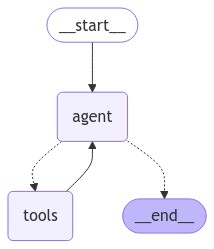

In [24]:
# Display the workflow graph as a Mermaid diagram using the application's graph representation
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
# Add a thread ID to the configuration for saving the conversation.
# This ensures that each conversation is saved and context is retained.

config = {"configurable" : {"thread_id" : "2"}}

In [31]:
# Welcome message for the user and instructions on how to exit the chatbot
print("Welcome to Insurance Documentation Chatbot. Please enter your query. Type 'exit' to quit.")

# Get the user's input query and print it to the Output cell
query = input()
print("User: ", query)

# Continue the conversation until the user types 'exit'
while query != 'exit':
    data = []  # Initialize a list to store the chatbot's responses
    
    # Stream the chatbot's responses based on the user's query
    for chunk in app.stream({"messages": [("human", query)]}, stream_mode="values", config=config):
        #print(chunk)  # Print the raw response chunk. Uncomment this for debugging
        data.append(chunk["messages"][-1].content)  # Append the chatbot's response to the data list
    
    # Print the last response from the chatbot
    print("Chatbot: ", data[-1])

    print("-"*100)
    
    # Get the next query from the user
    query = input()
    print("User: ", query)

# Thank the user for using the chatbot when they exit
if 'exit' in query.lower():
    print("Thanks for using Insurance Documentation Chatbot. Have a great day!")
    print("-"*100)

Welcome to Insurance Documentation Chatbot. Please enter your query. Type 'exit' to quit.
User:  is Alzheimer's Disease covered under critical illness benefits?
Chatbot:  Yes, Alzheimer's Disease is covered under critical illness benefits as specified in the policy document.

<Reference>
Page 7 | Comprehensive Guide to Insurance Benefits: Coverage for Death, Accidental Death, and Critical Illness | HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
----------------------------------------------------------------------------------------------------
User:  what is Alzheimer's Disease?
Chatbot:  Alzheimer's Disease is a progressive, neurodegenerative brain disorder that affects memory, thinking, and behavior. It is the most common cause of dementia, leading to a decline in cognitive functions severe enough to interfere with daily tasks.

<Reference>
Answer retrieved from internet search. Please contact the Agent/Customer Care executive for more details.
-----------------------

In [27]:
# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [("user", user_input)]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     user_input = input("User: ")
#     if user_input.lower() in ["quit", "exit", "q"]:
#         print("Goodbye!")
#         break

#     stream_graph_updates(user_input)

In [28]:

# print("Welcome to Insurance Documentation Chatbot. Please enter your query. Type 'exit' to quit.")
# chat_history = []
# query = input()
# print("User: ", query)
# while query != 'exit':
#     response = agent.invoke({"input": query})
#     #chat_history.append({"input": query, "output": response['output']})
#     #cache.set(response['input'], response['output'], expire=600)
#     print("Chatbot: ", response['output'])
#     query = input()
#     print("User: ", query)

# if 'exit' in query.lower():
#     print("Thanks for using Insurance Documentation Chatbot. Have a great day!")



# #agent.run("What is the procedure to claim the insurance?")